# Readme



All data collected in Project Echo are grouped into buckets.

The following Readme accompanies every bucket of data and provides a complete summary of each bucket accurate of 220923.

Additonal, this document provides a pipeline that stores the audio data in a .csv file and allows for downstream Pandas intergration and analysis.

A subset from the data bucket, *project_echo_b3* was used for this demonstration.

> Author: Balram Veeragoo Naidu

> Author: Atharva Shridhar Kulkarni

---

# List of Project Echo Data Buckets



> 1) *project_echo_bucket 1*

> 2) *project_echo_bucket 2*

> 3) *project_echo_bucket 3*

> 4) *project _echo_birdclef*

# Summary and Source

1) *project_echo_bucket 1*-: This contains simulator samples. It has been cross referenced with roughly 227 otways species.

2) *project_echo_bucket 2*-: This is the master database which contains samples of over 400 species that are not in Otways region.

3) *project_echo_bucket 3*-: This bucket contains cleaned up audio legacy data clips of up to 10s each with silences filtered out.

4) project _echo_birdclef-: This bucket contains dataset for testing and training purposes. This is a subset of project_echo_bucket 1 containing small samples of 227 otways species.

All buckets and instructions on how to access this data can be retrieved here:
> https://github.com/DataBytes-Organisation/Project-Echo/blob/main/src/Components/Store/README.md

# Imports and Dependencies


The Magic Library needs to be installed for this pipeline. To do so; 

Follow library installation guide here:
https://github.com/ahupp/python-magic

In [1]:
#All Imports

import os
import magic
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pydub import AudioSegment
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

# Code Pipeline


In [2]:
#Define Path
dataset_dir = 'E:/b3'

**Database structure and Distribution**



1.   Main Folder

     The main folder is the top level container/directory of the dataset. It reflects the name of the Data Bucket, i.e. The main      folder for *project_echo_bucket_1* is *project_echo_bucket_1*.


2.   Sub Folders
     
     Sub folders are contained within the main folders and categorize the data based on the name of the species. e.g. Cacatua        tenuirostris.

When running this pipeline, ensure that the dataset is organised in this 2 level way.

In [3]:
# Initiating an Empty list
audio_info_list = []

In [4]:
import os

# Counting the number of audio files in each subfolder
folder_audio_file_count = {}

# Iterate through subdirectories in the root directory
for root, _, files in os.walk(dataset_dir):
    audio_file_count = 0

    for audio_file in files:
        if audio_file.endswith(('.wav', '.mp3', '.ogg', '.acc', '.flac')): # Common audio formats; can be appended to add new ones
            audio_file_count += 1

    # Extract the relative subfolder path
    relative_folder = os.path.relpath(root, start=dataset_dir)

    # Store the count in a dictionary using the subfolder path as the key
    folder_audio_file_count[relative_folder] = audio_file_count

# Print the number of audio files in each subfolder
for folder, audio_count in folder_audio_file_count.items():
    print(f"Subfolder: '{folder}' - Audio Files: {audio_count}")

# Summing counts from all subfolders for audio files
total_audio_files = sum(folder_audio_file_count.values())
print(f"\nTotal number of audio files in all subfolders: {total_audio_files}")


Subfolder: '.' - Audio Files: 0
Subfolder: 'Aegotheles Cristatus' - Audio Files: 146
Subfolder: 'Alauda Arvensis' - Audio Files: 96
Subfolder: 'Caligavis Chrysops' - Audio Files: 124
Subfolder: 'Capra Hircus' - Audio Files: 86
Subfolder: 'Cervus Unicolour' - Audio Files: 34
Subfolder: 'Colluricincla Harmonica' - Audio Files: 60

Total number of audio files in all subfolders: 546


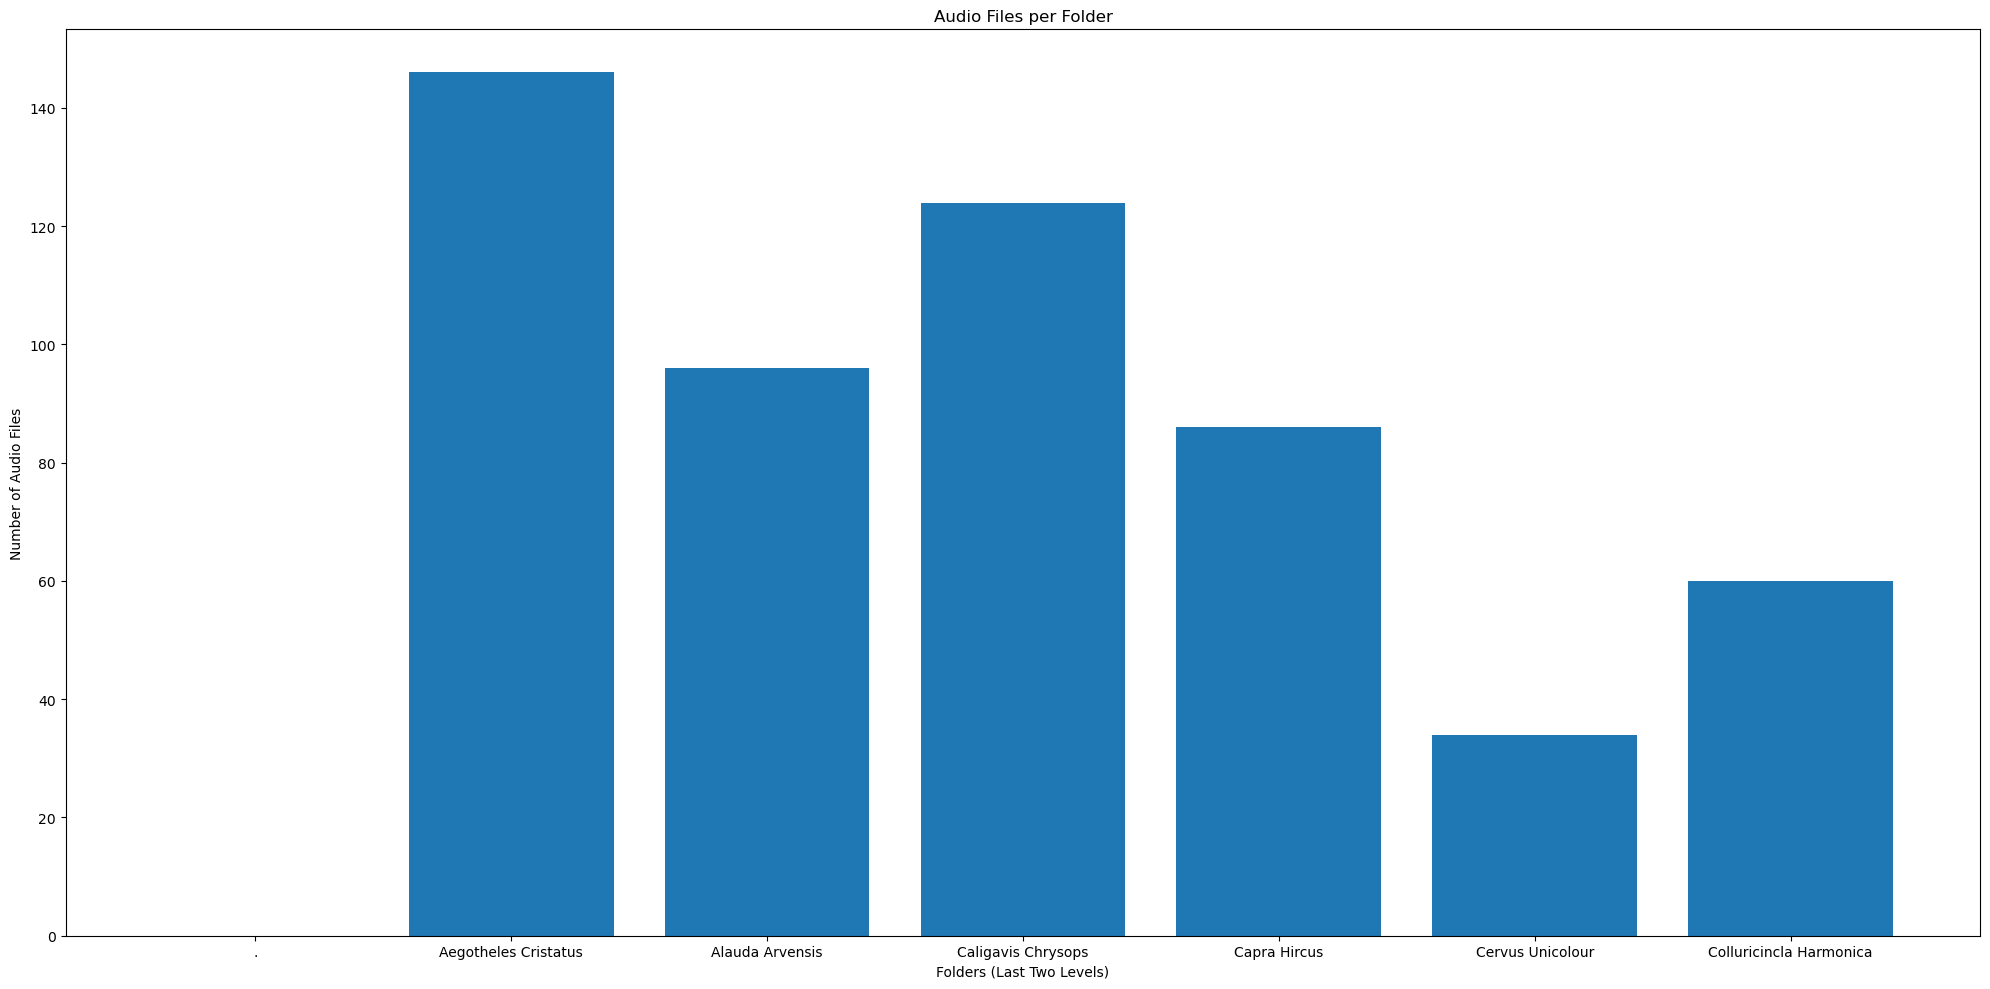

In [5]:
# Last two levels of the folder for x-axis labelling
shortened_folders = [os.path.join(*folder.split(os.sep)[-2:]) for folder in folder_audio_file_count.keys()]

# Bar Chart for Visualization of Distribution
audio_counts = list(folder_audio_file_count.values())

plt.figure(figsize=(20, 10))
plt.bar(shortened_folders, audio_counts)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Folders (Last Two Levels)')
plt.ylabel('Number of Audio Files')
plt.title('Audio Files per Folder')
plt.tight_layout()
plt.show()

**Creating full Summary Stat Sheet CSV for Data Bucket**

This section of the code collects audio metadata using the Magic Library, which is then subsequently stored as a .csv file.

The error processing functionaly, ensures that the pipeline still progresses, if the event of corrupted files.

In [6]:
# Searching for audio files in subfolders

#Corrupted Files List
corrupted_files_list = []

for root, _, files in os.walk(dataset_dir):
    for audio_file in files:
        if audio_file.endswith(('.wav', '.mp3', '.ogg', '.acc', '.flac')):
            file_path = os.path.join(root, audio_file)
            folder_name = os.path.basename(root)

            try:
                # File size in bytes (For Memory Requirements)
                file_size = os.path.getsize(file_path)

                # File type detection (Using Magic Library)
                mime = magic.Magic()
                file_type = mime.from_file(file_path)

                # Audio length in milliseconds
                audio = AudioSegment.from_file(file_path)
                audio_length = len(audio)

                # Dictionary to store information
                audio_info = {
                    "species_name": folder_name,
                    "file_name": audio_file,
                    "file_size_bytes": file_size,
                    "file_type": file_type,
                    "audio_length_ms": audio_length,
                    "status": "success" #Indicates non corrupt files
                }

                # Append the dictionary to the list
                audio_info_list.append(audio_info)

            except Exception as e:
                # Handle the exception and print an error message
                error_message = f"Error processing {file_path}: {str(e)}"
                print(error_message)

                corrupted_file_info = {
                    "species_name": folder_name,
                    "file_name": audio_file,
                    "status": "error"  # Indicates an error/corrupted file in the dataset during processing
                }

                corrupted_files_list.append(corrupted_file_info)

In [7]:
# Define the name of the CSV
csv_filename = 'b3_test.csv' #Change file name accordingly

# CSV fieldnames (column headers)
fieldnames = ["species_name", "file_name", "file_size_bytes", "file_type", "audio_length_ms", "status"]

# Writing to CSV file
with open(csv_filename, mode='w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Headers
    writer.writeheader()

    # Writing Audio Info
    for audio_info in audio_info_list:
        writer.writerow(audio_info)

    # Writing Corrupted Audio Info
    for corrupted_file_info in corrupted_files_list:
        writer.writerow(corrupted_file_info)

print(f"Audio information has been saved to {csv_filename}") #Saves .csv file to directory

Audio information has been saved to b3_test.csv


**Example Audio and Spectrogram Files**

Playing audio file: E:/b3\Aegotheles Cristatus\00001-0.wav


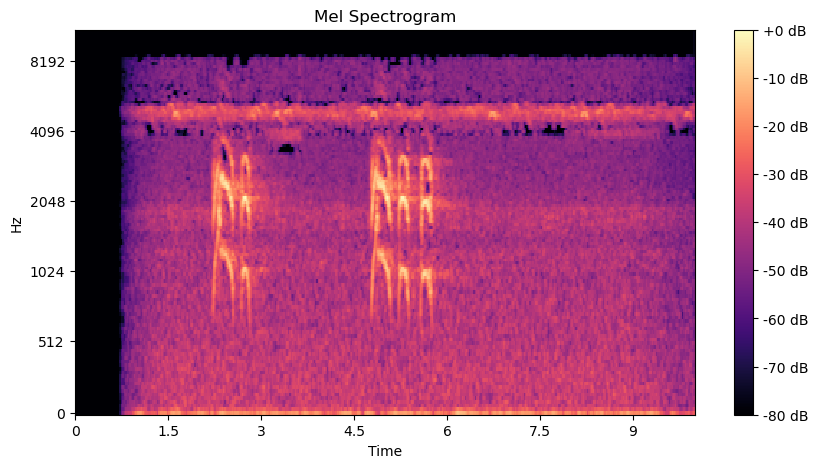

Playing audio file: E:/b3\Alauda Arvensis\0293_Feldlerche_Gesang_short-0.wav


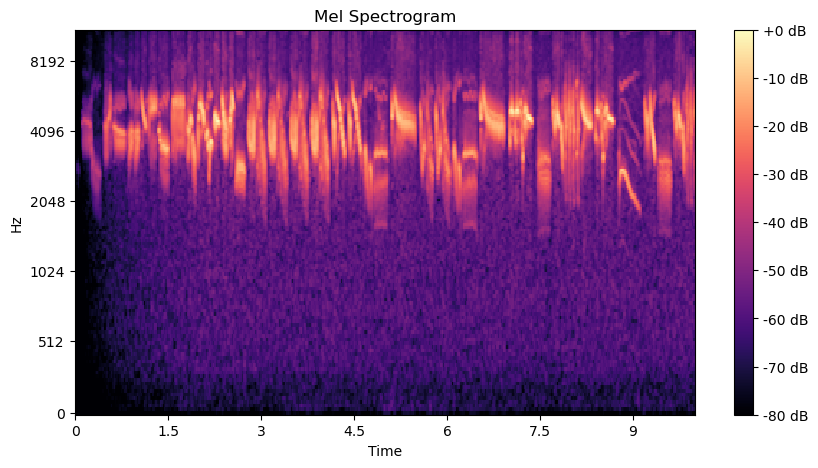

Playing audio file: E:/b3\Caligavis Chrysops\X00881-8.wav


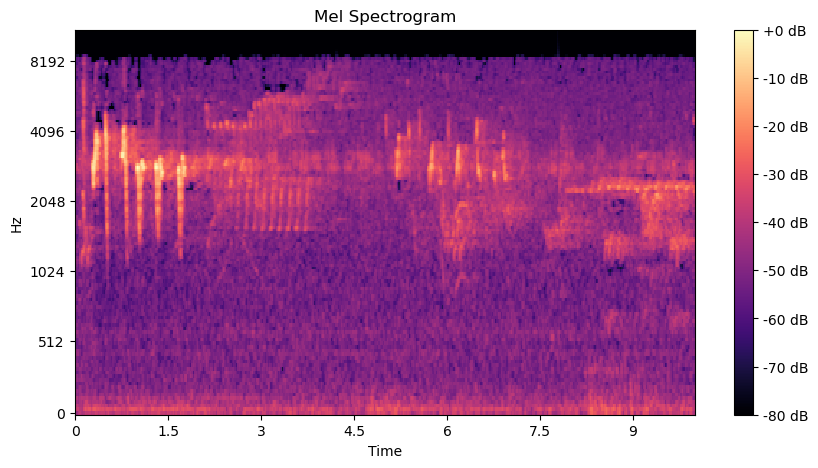

Playing audio file: E:/b3\Capra Hircus\0552_Hausziege_Bulgarische_Langhaarziege_Bock_short-0.wav


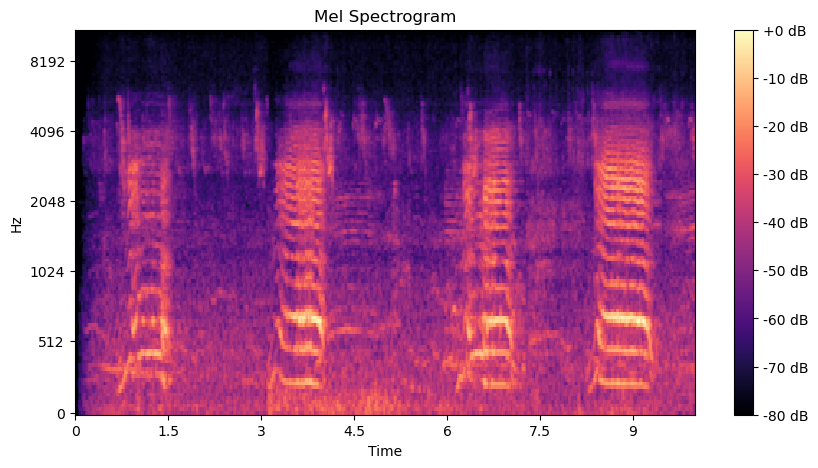

Playing audio file: E:/b3\Cervus Unicolour\056374-0.wav


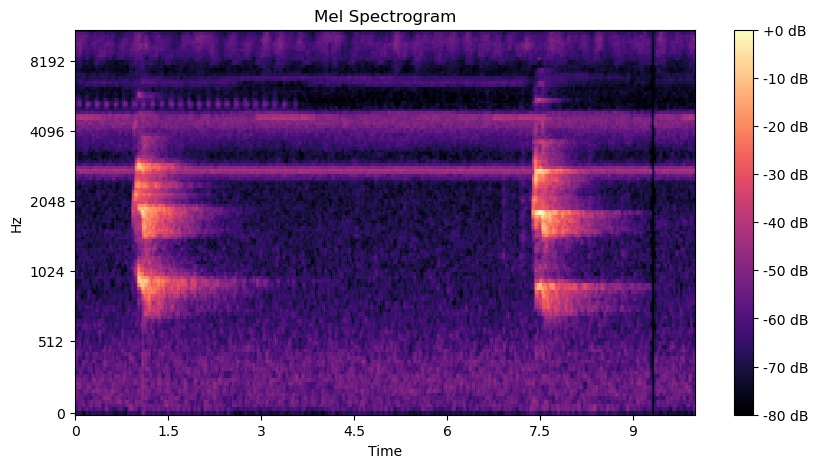

Playing audio file: E:/b3\Colluricincla Harmonica\X01228-5.wav


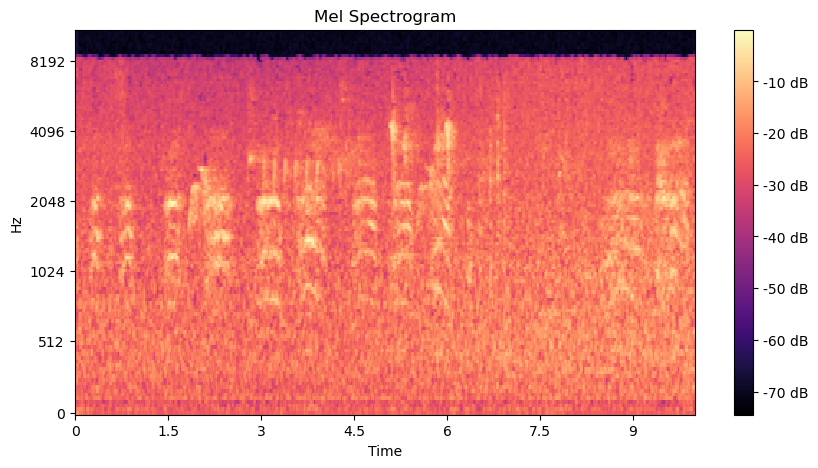

In [8]:
#Plays first file of each folder and print out its respective Mel Spectrogram
for root, _, files in os.walk(dataset_dir):
   for audio_file in files:
       if audio_file.endswith(('.wav', '.mp3', '.ogg')):
           audio_file_path = os.path.join(root, audio_file)

           # Play audio file
           print(f"Playing audio file: {audio_file_path}")
           display(Audio(audio_file_path))

           # Loading audio data with librosa
           audio_data, sr = librosa.load(audio_file_path)

           # Creating Mel spectrograms
           mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)

           # Plotting Mel spectrograms
           plt.figure(figsize=(10, 5))
           librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
           plt.colorbar(format='%+2.0f dB')
           plt.title('Mel Spectrogram')
           plt.show()
           break

# Pandas Analysis - 

**Issues in the data, Duplicate File Names, Empty Values etc.**

The code below is a template for Panda Analysis. Additional functions can be added for deeper analysis.

In [9]:
import pandas as pd

# CSV file path
csv_filename = 'Add .csv File path here'

# Reading into a DataFrame
df = pd.read_csv(csv_filename)

#Function for checking duplicates in data
def check_duplicates(df):
  duplicated_file_name = df[df.duplicated(subset="file_name", keep=False)]

  if not duplicated_file_name.empty:
    duplicated_species_name = duplicated_file_name[duplicated_file_name.duplicated(subset="species_name", keep=False)]

    if not duplicated_species_name.empty:
      print("Duplicated values in file_name and species_name:")
      print(duplicated_species_name)

    else:
      print("Duplicated values in file_name:")
      print(duplicated_file_name)

  else:
    print("No duplicated values in dataset found.")

#Function for checking empty values
def check_empty_rows(df):

    empty_rows = df[df.isnull().any(axis=1)]

    if not empty_rows.empty:
        print("Rows with empty values:")
        print(empty_rows)

    else:
      print("No rows with empty values found.")

#Checking df
check_duplicates(df)
check_empty_rows(df)

No duplicated values in dataset found.
No rows with empty values found.


# Data Cleaning

**1.   How clean is the data?**

- The datasets predominantly comprises short clips, each lasting no more than 2 seconds, capturing distinct vocalizations. To ensure clarity and relevance, intervening silences—unless they demarcate consecutive vocalizations—are meticulously eliminated. Moreover, we've undertaken rigorous filtering to exclude ambient disturbances, including weather elements like rain, artificial disruptions, and human chatter. Consequently, the refined dataset showcases vocalizations, with minimal exceptions involving slightly intertwined sounds. It's worth noting that the precision of these vocalizations is paramount; only the crispest and most discernible sounds are acknowledged and preserved by the YamNet model.

**2. What was done to clean it?**

- **CSV Dictionary Integration:** Within this code segment, audio files are meticulously mapped to their respective scientific names. Subsequently, a dedicated directory is instantiated to archive events derived from the audio file, governed by its corresponding CSV index. This index not only enumerates audio filenames but also aligns them with the pertinent scientific nomenclature of the avian subjects featured therein.

- **Event Segmentation Module:** This component delves into the audio file, segmenting it into discrete regions based on event detection. The demarcation of these regions is realized through a sophisticated energy thresholding mechanism, ensuring precision in capturing significant audio events.

- **YamNet Classification:** Upon segmentation, these discerned regions are channeled to the YamNet classifier. This classifier undertakes the pivotal task of categorizing each region. It is only when a region resonates with the distinct vocal attributes of birds (or potentially other animals for diverse datasets) that it merits archiving in the pre-established directory, named in accordance with the bird's scientific designation.

- **Manual Cleaning:** Bucket 1 was meticulously cleaned by deleting any data that was not representative of the species. This includes human voices, other animal sounds, files with no species vocalisations and any additional non representative files.